Convert this talk to a HTML preserntation via  
`jupyter nbconvert talk.ipynb --to slides`

https://medium.com/@mjspeck/presenting-code-using-jupyter-notebook-slides-a8a3c3b59d67

In [1]:
# Import packages, prepare data
# (TODO paste the file in here later again. I just don't like scrolling all the time while drafting this notebook)

%run setup.py

![title](img/title.jpg)

- <img src="img/twitter.svg" style="height: 20px; float: left" /> &nbsp; @eng_elhardt
- <img src="img/github.svg" style="height: 20px; float: left" /> &nbsp; AlexEngelhardt (slides: https://github.com/AlexEngelhardt/iml-talk)
- Longer blog post available at https://www.alpha-epsilon.de/blog/

## Outline

- Intro: Problems in ML models
- Interpretable Machine Learning (IML) / Explainable AI (XAI)
- How to achieve interpretability
  - 1: Use interpretable models
  - 2: Post-hoc model-agnostic methods
- Data & Model
- Model-agnostic methods
  - Taxonomy
  - Permutation Feature Importance
  - Partial Dependence Plots
  - Shapley values / SHAP
- Other methods not covered here
- The future of IML

# Intro: Problems in ML models

- We like automatization
- ML models automatize easy decisions
- $\Rightarrow$ we like ML
- But: They are not pure advantage, but come with a few problems:

### Problem 1: Fairness

Story source: https://appsilon.com/please-explain-black-box/

- In October 2018 world headlines reported about [Amazon AI recruiting tool](https://www.theguardian.com/technology/2018/oct/10/amazon-hiring-ai-gender-bias-recruiting-engine) that favored men. Amazon’s model was trained on biased data that were skewed towards male candidates. It has built rules that penalized resumes that included the word “women’s”.
- Solution: PFI

### Problem 2: Understanding

- Many of us ultimately want to use datasets to extract scientific knowledge. A 98% accurate Random Forest is no good if we can't extract an explanation from the model. (Roscher 2019)
- Scientific disciplines (e.g biology) use more and more ML for producing scientific outcomes. Their ultimate goal is not a correct model, but *knowledge*. IML extracts knowledge from a trained model.
- Solution: PDPs

### Problem 3: Explainability and Debugging

- In February 2019 the Polish government added an amendment to a banking law that gives a customer a right to receive an explanation in case of a negative credit decision. It’s one of the direct consequences of implementing GDPR in EU. This means that a bank needs to be able to explain why the loan wasn’t granted if the decision process was automatic.
- The EU's GDPR states: "[the data subject should have] the right ... to obtain an explanation of the decision reached". 

- Debugging and auditing (why does my model misclassify all <18 year olds?) is only possible when a model can be interpreted. An interpretation for a wrong prediction helps to understand the cause of the error and point you to what kind of additional training data you'll need.  Knowing *why* a model made a decision helps you to learn more about the problem, the data, and the reason why a model might fail.
  - Also, if you understand your model well, you're better equipped for feature engineering, or even deciding to replace your model with a different one.

<img src="img/husky-vs-wolf-LIME-paper.png" style="height: 200px" />

- Solution: Local methods, such as Shapley Values / SHAP
- Solution: Get more pictures from Huskys in Alaska

# Lesson

- Lesson: The need emerges to be able to look under the hood of machine learning models and *understand* their behavior.
- This talk aims to be an introduction into the field and its methods.
- Because our loss function is often just one part of what we really want to optimize¹. Additional criteria that are not covered by the loss function:
  - fairness, explainability (as mentioned before),
    - This might also increase social acceptance of AI models
  - but also safety: You want to be 100% certain the abstraction for "cyclist" a DL driving model learned is correct. Imagine the model learned to "see" two wheels, then you'd run over bikes with side bags.
- These criteria often cannot be quantified. E.g. we can't enumerate and write all unit tests required to let an autonomous car drive completely safely.
- Interpretability is a popular fallback: If the system can /explain/ its reasoning, we can verify whether that reasoning makes sense with respect to these auxiliary criteria.
    
¹ Doshi-Velez et al., 2017

# Interpretable Machine Learning (IML) / Explainable AI (XAI)

> "Interpretability is the degree to which a human can understand the cause of a decision"
>
> -- Miller, Tim. "Explanation in artificial intelligence: Insights from the social sciences." [arXiv:1706.07269](https://arxiv.org/abs/1706.07269)

- A relatively young field, changes quickly, diverse terminology, research papers at high speed
  - Theory and nomenclature is not yet unified.
    - cf. https://twitter.com/mattia_ferrini/status/1164124764392304640
- This talk is based on Christoph Molnar: Interpretable Machine Learning
  - Available free at https://christophm.github.io/interpretable-ml-book/
  - R-package [iml](https://cran.r-project.org/web/packages/iml/index.html)
    - A port to Python would be great!

<img src="img/iml-book.jpg" style="height: 200px" />

# How to achieve interpretability

We use IML because we want to be able to *trust* the predictions.

- Option 1: Use interpretable models
- Option 2: Use black-box models and post-hoc interpretation methods

# Option 1: Use interpretable models

- Models are intrinsically interpretable because they are heavily constrained. Either to linear relationships (like LM) or to monotonous relationships (like logistic regression; they make it easier to understand a relationship) (Molnar pg 49)
- like LM
	 - Always a nice first choice :3
	 - disadvantages: Molnar pg69
	   - can be unintuitive: rent ~ qm + #rooms, beta_#rooms will be negative!
- Or decision trees
	 - They shine when there are nonlinear effects and/or interactions between features.
	   - TODO do we need to introduce interactions? If so, do it here. Maybe in the blogpost yes, but talk no (time :()
     - They have an inherent feature importance metric: The total node purity improvement (Molnar pg. 107)
     - disadvantages: Molnar pg108
	   - fail at linear relationships
	   - very unstable: perturb data, entirely different tree

# Option 2: Use black-box models and post-hoc interpretation methods

- Simple, interpretable models (t-tests, LM) are good when you want simple interpretability and have small datasets: E.g. medicine in the 80s.
- But: 
	 - Because interpretable models come with assumptions, i.e. they are not flexible enough for the real world (pg. 300, Molnar)
	 - Thus, interpretable models usually perform worse (this gets more true for bigger datasets, which has of course been the recent development)
- "Black Box" informally: A model that cannot be understood by looking at its parameters. Linear Model vs. Neural Network

# Data

- Bike sharing!
- aggregated to daily averages (sums for the `count` variable)

In [2]:
data.sample(2)

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
days_since_start,,,,,,,,,,,
430,spring,2012,no,tuesday,yes,clear,2.1,-3.2,45.7,13.5,3956
30,spring,2011,no,monday,yes,mist,-0.9,-6.7,60.4,12.5,1501


Dummy variables for a XGBoost model:

In [3]:
dummy_data.sample(2)

,year,temp,feel_temp,humidity,windspeed,count,season_autumn,season_spring,season_summer,season_winter,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,workingday_no,workingday_yes,weather_clear,weather_light rain,weather_mist
days_since_start,,,,,,,,,,,,,,,,,,,,,
321,2011,2.7,-2.4,41.0,11.3,3392,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
170,2011,16.8,13.8,74.6,10.4,4010,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0


# Model

- A linear model
- A random forest

In [4]:
X = dummy_data.drop('count', axis=1)
y = dummy_data['count']

rf_mod = RandomForestRegressor(n_estimators=100)
rf_mod.fit(X, y)

lm_mod = LinearRegression()
lm_mod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
print('LM:', mean_absolute_error(y, lm_mod.predict(X)))
print('RF:', mean_absolute_error(y, rf_mod.predict(X)))

LM: 577.064364441647
RF: 172.83075239398084


# Interpretation Methods

- Focus is on model-agnostic methods
  - First train the model, then work on interpreting it
  - Basic idea: Wiggle the input data and measure changes in the predicted output
- Model-agnostic methods have a few advantages: (Ribeiro++ 2016)
  - Flexible regarding models: You can use any model "below" it, as complex as you want.
	- You can replace the ML model anytime (low switching cost), and can compare different models in terms of interpretability. Before, you might have had a unwanted multi-objective optimization between a model that performs better but is less interpretable, and another that performed worse but is better interpretable. Those times are gone!
  - Flexible regarding explanations: Different model users might care about different explanations (e.g. ML engineers: feature importance vs. legal dept: feature effects vs. customers: What affected their own single prediction?).
  - Flexible regarding feature representations: You can swap out the features between training and interpreting: Train your document classifier with word embeddings, but explain its prediction using a RuleFit algorithm on the actual (interpretable) words.

<img src="img/big-picture.png" style="height: 90%" />

Source: Molnar 2019

# Interpretation Methods

- As always, the answer to "which method" is "it depends". What do you want to understand? The global model or a local prediction? Do you only want to understand the importance of each feature, or also the amount of its contribution? Are there constraints from the legal department (must all features be explained? is the main target to avoid minority bias?)?
  - Do you want to understand the *global* model behavior, or do you want to explain a *single* data instance and why a specific prediction was made?
  - Do you want to understand the *importance* of a feature, or the *effect size* of a feature?

----

- Global methods that explain global model behavior across all data instances
  - Partial Dependence Plots
    - feature effect
  - Permutation Feature Importance
	- feature importance
- Local methods that explain invididual predictions
  - Shapley Values
	- feature effect / TODO they can be seen as the feature importance for a single instance too, right?



# Permutation Feature Importance

- First described in Breiman's 2001 Random Forest paper
- Intuition: Molnar pg 301
  - In a linear model, the **standardized feature coefficient** (or: p-value) measures the importance of a single feature for the predicted outcome. PFIs are the generalized, model-agnostic version of this.
- The feature importance automatically captures interaction effects/importance too
- Algorithm
  - Shuffle the column of interest
  - Predict with true data
  - Predict with shuffled data
    - /* No retraining of the model necessary! */
  - Take difference between losses
  - Compute pointwise average

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

In [7]:
# Ideally you'd compute feature importance on test data

rf_perm = PermutationImportance(rf_mod).fit(X, y)

eli5.show_weights(rf_perm, feature_names=list(X.columns))

Weight,Feature
0.5885 ± 0.0351,year
0.4110 ± 0.0199,temp
0.1057 ± 0.0039,humidity
0.1000 ± 0.0073,feel_temp
0.0560 ± 0.0081,season_spring
0.0458 ± 0.0047,windspeed
0.0416 ± 0.0097,season_winter
0.0382 ± 0.0069,weather_light rain
0.0064 ± 0.0011,weather_clear
0.0049 ± 0.0014,season_summer


### Problem 1: Fairness

- PFI handle this problem because now you see how much each feature (e.g. gender) contributes to the predictions

# Partial Dependence Plots

- First described in Friedman's 2001 Gradient Boosting Machine paper
- Intuition: Molnar pg. 301:
  - In a linear model, the **feature coefficient** measures the effect of a single feature on the predicted outcome. PDPs are the generalized, model-agnostic version of this.
- Algorithm (for categorical variables - most intuitive, for the beginning)
  - For each feature value (e.g. spring, summer, autumn, winter):
    - Force the entire dataset's `season` to this feature value (e.g. winter)
    - Keep all other features the same
    - Predict $\hat{y}$
    - Average the predictions

In [8]:
# sklearn.inspection needs sklearn >=0.21

from sklearn.inspection import partial_dependence, plot_partial_dependence

In [ ]:
X.columns

Index(['year', 'temp', 'feel_temp', 'humidity', 'windspeed', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter', 'holiday_no',
       'holiday_yes', 'weekday_friday', 'weekday_monday', 'weekday_saturday',
       'weekday_sunday', 'weekday_thursday', 'weekday_tuesday',
       'weekday_wednesday', 'workingday_no', 'workingday_yes', 'weather_clear',
       'weather_light rain', 'weather_mist'],
      dtype='object')

In [ ]:
seasons = ['season_spring', 'season_summer', 'season_autumn', 'season_winter']
PDs = pd.Series(np.nan, index=seasons)
for season in seasons:
    X_temp = X.copy()
    for S in seasons:
        X_temp[S] = 0
    X_temp[season] = 1
    PDs[season] = rf_mod.predict(X_temp).mean()

In [ ]:
# PD on 'season', *given* everything else (e.g. temperature) stays the same:
PDs

season_spring    4024.295431
season_summer    4489.709808
season_autumn    4566.372134
season_winter    4889.040342
dtype: float64

In [ ]:
data.groupby('season')['count'].mean()

season
autumn    5644.303191
spring    2604.132597
summer    4992.331522
winter    4728.162921
Name: count, dtype: float64

In [ ]:
data['yhat'] = rf_mod.predict(X)
print(data.groupby('season')['yhat'].mean())
data.drop('yhat', axis=1, inplace=True)

season
autumn    5630.759149
spring    2638.641271
summer    5008.809457
winter    4718.278708
Name: yhat, dtype: float64


## Why are the PDs so different from the group means?

- Here, we use *every* instance for every category
- Here, we evaluate a model, i.e. the *predictions* for $\hat{y}$, and the effect on *them*
- But most importantly:
- Feature interactions are marginalized out:
  - Group means of `winter` contain only observations with -10°C
  - Manipulated data contains observations with +30°C and manipulated season `winter`
  - $\Rightarrow$ The *pure* effect of season is not so high

This becomes clear once we compute ICEs, i.e. a PDP for *one* observation:

In [ ]:
i = 234
one_obs = X.iloc[i:(i+1), :]  # weird syntax keeps it a DF instead of a Series

seasons = ['season_spring', 'season_summer', 'season_autumn', 'season_winter']
PDs = pd.Series(np.nan, index=seasons)
for season in seasons:
    one_obs_temp = one_obs.copy()
    for S in seasons:
        one_obs_temp[S] = 0
    one_obs_temp[season] = 1
    PDs[season] = rf_mod.predict(one_obs_temp).mean()

# PD on 'season', *given* everything else (e.g. temperature) stays the same:
PDs

season_spring    4649.57
season_summer    5528.28
season_autumn    5596.50
season_winter    5552.87
dtype: float64

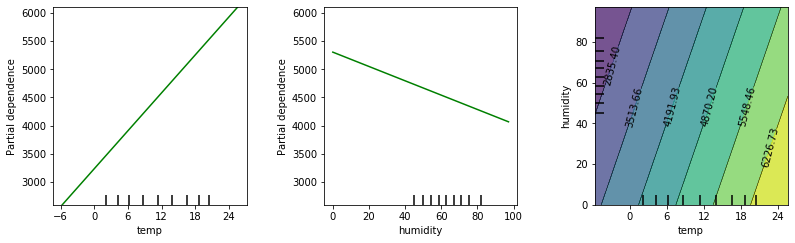

In [ ]:
# small vertical lines are the data's deciles

fig, ax = plt.subplots(1, 3, figsize=(12,5))

plot_partial_dependence(lm_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))


plot_partial_dependence(rf_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

Here you see the main problem in linear models: They assume a linear relationship with temperature.

- 5°C: 4100 bikes
- 10°C: 4800 bikes
- $\Rightarrow$ 50°C: 15'000 bikes!


### Problem 2: Understanding

PDPs are one solution to this problem because we obtain the marginalized feature effect for each feature.

# SHAP / Shapley Values

https://christophm.github.io/interpretable-ml-book/shap.html

https://github.com/slundberg/shap

- "How to fairly distribute the prediction among the features?" How much does each feature contribute?
  - e.g. predict an apartment sale price of 320'000€. It has 64 sq.m., is in the 5th floor, does not allow pets, has a balcony. How did each feature influence the prediction? Maybe: Average prediction is 300'000€. Then 64sq.m. contributed 15'000€, balcony contributed 7'000€, no-cats-allowed contributed -2'000€.
  - For linear models, each feature's contribution is easy: $\beta_j \cdot x_j$
- Based on game theory:
  - The "game" is the prediction task for one single instance
  - The "gain" is the actual prediction minus the average prediction of all instances.
  - The "players" are the feature values that collaborate to receive the gain (= predict a certain value)
  - Features act as a coalition
  - Shapley value: assign payouts to players depending on their contribution to the total payout

# Computing Shapley values

- A bit complex
- TODO only the intuition?

In [ ]:
import shap

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(rf_mod)

In [ ]:
X_sub = X.sample(100, random_state=20190818)

In [ ]:
shap_values = explainer.shap_values(X_sub)  # takes long

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# Shapley Values

- Visualize Shapley Values as *forces*
- The Shapley values are *additive* importance measures
- They move the prediction away from the *base value* (the average prediction over all instances)

In [ ]:
# why not == base value?
rf_mod.predict(X).mean()

In [ ]:
i = 20
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[i,:], X_sub.iloc[i,:])

# "Why didn't we make any revenue on this day? It was a perfect 15°C!"
#
# "Yes the temperature on that day was good for bike rentals, but that effect 
# was nullified again by the high humidity"

# Shapley-based feature importance

- A simple measure of feature importance is the average *absolute* Shapley value for each feature
- These plots are an alternative to permutation feature importance discussed earlier. But:
- There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.
  - https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance

In [ ]:
shap.summary_plot(shap_values, X_sub, plot_type="bar")

# SHAP dependence plot

SHAP feature dependence might be the simplest global interpretation plot: 

1. Pick a feature.
2. For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis.

----

- These plots are an alternative to partial dependence plots discussed earlier. But:
- While PDP and ALE plot show average effects, SHAP dependence also shows the variance on the y-axis. Especially in case of interactions, the SHAP dependence plot will be much more dispersed in the y-axis. 

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("temp", shap_values, X_sub, interaction_index=None)

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("temp", shap_values, X_sub, interaction_index='humidity')

- Shapley values also work for grouped features: E.g. superpixels in images
- There are many other cool measures and plots based on Shapley values
- Once you understand them, you can use the principle for your entire interpretability suite!

### Problem 3: Explainability

- Shapley Values solve this problem because now you can visualize the size of each feature that contributed to a loan being rejected.


# Other methods not covered here

- Other global models
  - ALEs, because PDPs suffer when features are correlated
- Other local, i.e. example-based methods
  - Counterfactual Explanations
	 - We tend to think in counterfactual cases. If we apply for a loan and get rejected, the best explanation for a human would be something like "if you earned 10'000€ more AND if you had paid that electricity bill in 2010, you'd been low-risk" (Molnar pg. 36-37)
	 - A counterfactual explanation is the "smallest change" to the feature values that changes the prediction to a predefined output (Molnar pg. 241)
  - Adversarial Expamples
     - TODO lightning talk
     - An adversarial example is an (artificial) instance with small changes in the features, that trick the model into making a false prediction.
	 - https://christophm.github.io/interpretable-ml-book/images/adversarial-turtle.jpg
	   - This turtle looks like a rifle from many angles and zoom levels.
       - It's not a big leap now to design a rifle that gets classified as a turtle.
	 - Adversarial examples make the ML model vulnerable to attacks. If you know them, you can use them in an updated training set. If your opponent knows them, he can get a loan, pass your gun detection AI, or make your car run over a stop sign (there are stickers for that)

----

- Refer to Molnar 2019 for everything

# The Future of Interpretable Machine Learning

- ML will grow because it *automatizes* decision making, and everyone likes automatization
- IML helps through:
	 - Hesitant adaptors that want predictions explained and demand some transparency (also due to legal reasons)
     - We need IML because we are never able to perfectly specify our goal to the computer. He stupidly does *exactly* what we tell him to. (Molnar pg 296). You specify an imperfect or a proxy goal (e.g. corporation: maximize profit for shareholders), and the "system" (e.g. model) might find a solution you didn't want (e.g. through imperfect training data).
- IML can be used to reverse engineer or game a model. Credit score models are better left uninterpreted (for the public), because people that still stay a risky debtor can just give back two credit cards to increase their score. This works for features that have a correlation influence (not causation influence) on the target. *Causal* features are not gameable. (pg. 25 Molnar)
- As I said, It's a relatively new field of research. Things change, papers come at high speed.
  - One step forward: The SIPA paper
  - Many interpretation methods operate with the same workflow.
  - Scholbeck et al. (2019) summarized it into *the SIPA framework*
     - Sampling
       - You'll be predicting /a lot/. If the prediction function takes too long, use just a sample of your data
     - Intervention
       - Change some feature values in input data
       - Memorable metaphor: Permuted instances as "Frankenstein's Monster" (Molnar pg 231)
     - Prediction
       - Predict y using the intervened data
     - Aggregation
       - E.g. average local predictions (ICEs) to global ones (PDs)
- Adversarial Machine Learning is a new field in Cybersecurity. More ML models deployed IRL, more entry points for attacks. (Biggio++ 2018)
	- Use IML to understand the weaknesses in your models. Be one step ahead of your competition.
- Model-agnostic methods will grow because of aforementioned flexibility.
- Like ML, IML will be automatized in the future (molnar pg 299). Like a test suite that runs after every code build, every retrained model gets an automatic report of feature importance, PDPs, a few surrogate models, etc.
- We won't die out, though. Today anyone can build websites without HTML, CSS, JS, but we still need web developers. Tomorrow, anyone can train a ML model, but we'll still need ML experts. (molnar pg 300)

![end](img/end.jpg)

- <img src="img/twitter.svg" style="height: 20px; float: left" /> &nbsp; @eng_elhardt
- <img src="img/github.svg" style="height: 20px; float: left" /> &nbsp; AlexEngelhardt (slides: https://github.com/AlexEngelhardt/iml-talk)
- Longer blog post available at https://www.alpha-epsilon.de/blog/

# References

   - Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.
   - Scholbeck CA, Molnar C, Heumann C, Bischl B, Casalicchio G (2019). Sampling, Intervention, Prediction, Aggregation: A Generalized Framework for Model Agnostic Interpretations. https://arxiv.org/abs/1904.03959
   - Doshi-Velez, Finale, and Been Kim. “Towards a rigorous science of interpretable machine learning,” no. Ml: 1–13. http://arxiv.org/abs/1702.08608 (2017).
   - Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Model-agnostic interpretability of machine learning." https://arxiv.org/pdf/1606.05386 (2016).
   - Biggio, Battista, and Fabio Roli. "Wild patterns: Ten years after the rise of adversarial machine learning." Pattern Recognition 84 (2018): 317-331. https://arxiv.org/pdf/1712.03141
   - Roscher, Ribana, et al. "Explainable Machine Learning for Scientific Insights and Discoveries." (2019). https://arxiv.org/pdf/1905.08883.pdf

# Bonus Slides

### IML on training or test data?

- Molnar pg. 194 (online: chap 5.5.2)
- tl;dr: It depends on what you want to know
- Imagine an overfitted SVM with 100 garbage features.
  - What feature importance would you expect? 
    - Zero because the features are noise? $\Rightarrow$ use test data
    - Or should they reflect how much the model depends on each feature? $\Rightarrow$ use training data

# Bonus Slides

### Correlations in features

- If features are correlated, partial dependence plots will be computed with unrealistic instances
- e.g. `temp = 20` degrees, but `feel_temp = -5`

In [ ]:
sns.scatterplot('temp', 'feel_temp', data=data)

- wat do?
- A method called *Accumulated Local Effects* (ALEs) is unbiased then
- See Molnar 2019